# Preliminary CIFAR-10 Analysis

Simple example using CIFAR-10 and a simple fast gradient sign attack. The same code should help to analyze other data we generate.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (16,9)
from matplotlib import colors
import random

from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
from bokeh.transform import dodge
from bokeh.models import ColumnDataSource, FactorRange, CustomJS, Range1d
from bokeh.layouts import widgetbox, column, gridplot, layout
from bokeh.models.widgets import Slider
output_notebook()

Loading BokehJS ...

In [2]:
df = pd.read_pickle(r"\\dom1\REDD\Groups\R1Q\Projects\AE_IRAD_2018\Data\Data_For_Evans_CIFAR_Experiments\Feb_9_2018_ell2\cifar10_stats_df_CH.pkl")

print(df.dtypes.index)

datasets = pd.unique(df['Dataset'])
examples = pd.unique(df['Example#'])

print('frame has %d datasets and %d unique examples' % (len(datasets), len(examples)))
print(datasets)

Index(['Approx_conf', 'Dataset', 'Example#', 'boundary_distance', 'delta_l2',
       'delta_loss', 'direction_id', 'direction_type', 'ell2_grad', 'k', 'y',
       'y_hat'],
      dtype='object')
frame has 21 datasets and 168 unique examples
['cifar10' 'FGM-10.00' 'FGM-2.50' 'FGM-5.00' 'I-FGM-1.50' 'I-FGM-10.00'
 'I-FGM-2.00' 'I-FGM-2.50' 'I-FGM-5.00' 'FGM-0.30' 'FGM-0.50' 'FGM-0.75'
 'FGM-1.00' 'FGM-1.50' 'FGM-2.00' 'I-FGM-0.30' 'I-FGM-0.50' 'I-FGM-0.75'
 'I-FGM-1.00' 'I-FGM-0.20' 'FGM-0.20']


In [26]:
df.head()

,Approx_conf,Dataset,Example#,boundary_distance,delta_l2,delta_loss,direction_id,direction_type,ell2_grad,k,y,y_hat
0,2.384989,cifar10,0,2.248105,NaN,1.184469,NaN,gradient,0.484421,NaN,3,1.0
1,2.384989,cifar10,0,80.000000,NaN,NaN,NaN,neg-gradient,0.484421,NaN,3,NaN
2,2.384989,cifar10,0,10.786918,NaN,1.111750,NaN,gaussian,0.484421,NaN,3,6.0
3,2.384989,cifar10,0,16.394444,NaN,1.034890,NaN,gaussian,0.484421,NaN,3,6.0
4,2.384989,cifar10,0,16.801848,NaN,1.163014,NaN,gaussian,0.484421,NaN,3,6.0


In [3]:
#replace infinities so we can show histograms.  Treat not finding a boundary distance as if it would take twice the distance we looked.
d_max = round(df.boundary_distance[df.boundary_distance != np.inf].max())
df.replace(np.inf, 2 * d_max, inplace=True)
print(d_max)
df.describe()

40.0


,Approx_conf,Example#,boundary_distance,delta_l2,delta_loss,direction_id,ell2_grad,k,y,y_hat
count,677082.000000,677082.000000,677082.000000,627690.000000,650432.000000,221088.000000,6.770820e+05,442176.000000,677082.000000,650432.000000
mean,2.652108,99.726010,8.158607,3.324474,0.660262,8.500000,9.891906e-01,18.000000,4.310899,4.454098
std,2.338897,57.848123,16.120693,3.170978,0.359330,7.589758,1.004614e+00,9.594931,2.721509,2.520458
min,0.002772,0.000000,0.000537,0.200000,-0.709602,0.000000,9.478230e-08,2.000000,0.000000,0.000000
25%,0.761852,50.000000,0.603393,1.000000,0.387862,2.000000,1.225919e-01,10.000000,2.000000,3.000000
50%,2.042913,101.000000,2.212985,2.000000,0.686018,6.000000,6.969594e-01,20.000000,4.000000,4.000000
75%,3.904595,151.000000,8.378677,5.000000,0.886245,13.000000,1.576323e+00,30.000000,6.000000,6.000000
max,17.031054,199.000000,80.000000,10.000001,1.994356,29.000000,5.932024e+00,30.000000,9.000000,9.000000


In [ ]:
ax = df.hist('boundary_distance', by=['Dataset', 'direction_type'], bins=np.linspace(0,40,80), figsize=(30,35), layout=(15,5))

In [ ]:
ax = df[df['Example#']==51].hist('boundary_distance', by=['Dataset', 'direction_type'], bins=np.linspace(0,40,80), figsize=(30,35), layout=(15,5))

In [27]:
example_stability = df[df.direction_type=='gaussian'].groupby(['Example#', 'Dataset'])['boundary_distance', 'k', 'delta_l2'].min()
#example_stability = example_stability.reset_index()

In [37]:
#example_stability.loc[0,'FGM-0.02'].k = 2
example_stability.head()
examp = 0
eps=2
dataset = 'FGM-2.00'
example_stability.loc[examp, dataset].k = df[(df['Example#'] == examp) & (df.Dataset == dataset) & (df.direction_type == 'gaas') & (df.boundary_distance < eps)].k.max()
#example_stability.head()

KeyError: 'the label [FGM-2.00] is not in the [columns]'

In [45]:
for dataset in df.Dataset.unique():
    for examp in df[df.Dataset == dataset]['Example#'].unique():
        eps = example_stability.loc[examp, dataset].boundary_distance / 5 #look up closest boundary
        x = df.loc[((df['Example#'] == examp) & (df.Dataset == dataset) & (df.direction_type == 'gaas') & (df.boundary_distance < eps)), 'k'].max()
        if np.isnan(x):
            example_stability.loc[(examp, dataset), 'k'] = 0
        else:
            example_stability.loc[(examp, dataset), 'k'] = x
        

In [54]:
example_stability.head()
tests = ['FGM-2.50', 'FGM-5.00']
example_stability.loc[0,tests,:]
df.Dataset.unique()

array(['cifar10', 'FGM-10.00', 'FGM-2.50', 'FGM-5.00', 'I-FGM-1.50',
       'I-FGM-10.00', 'I-FGM-2.00', 'I-FGM-2.50', 'I-FGM-5.00',
       'FGM-0.30', 'FGM-0.50', 'FGM-0.75', 'FGM-1.00', 'FGM-1.50',
       'FGM-2.00', 'I-FGM-0.30', 'I-FGM-0.50', 'I-FGM-0.75', 'I-FGM-1.00',
       'I-FGM-0.20', 'FGM-0.20'], dtype=object)

In [7]:
idx = pd.IndexSlice

In [66]:
low_attacks = ['FGM-1.00', 'FGM-1.50', 'FGM-2.00', 'FGM-2.50', 'I-FGM-1.50', 'I-FGM-1.00', 'I-FGM-2.00', 'I-FGM-2.50']
delta_epk = {}
for atk in low_attacks:
    delta_epk[atk] = {examp: ((example_stability.loc[examp,'cifar10'].boundary_distance / 5 - example_stability.loc[examp,atk].delta_l2), (example_stability.loc[examp,'cifar10'].boundary_distance - example_stability.loc[examp, atk].boundary_distance) / 5, (example_stability.loc[examp,'cifar10'].k - example_stability.loc[examp, atk].k))\
     for examp in example_stability.loc[idx[:, atk],:].index.get_level_values('Example#')}
#delta_k = {examp: example_stability.loc[examp,'cifar10'].k - example_stability.loc[examp,'FGM-0.02'].k for examp in example_stability.loc[idx[:,'FGM-0.02'],:].index.get_level_values('Example#')}

In [67]:
difs = {}
for atk in low_attacks:
    difs[atk] = pd.DataFrame.from_dict(delta_epk[atk], orient='index')
    difs[atk].columns = ['eps-2', 'cifar-ae', 'delta_k']
    #print(difs.delta_k.value_counts())

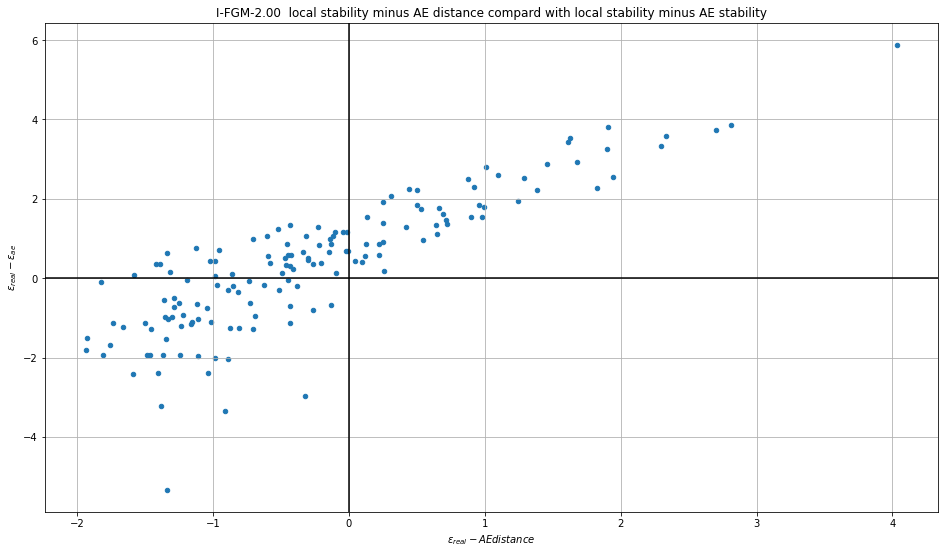

In [101]:
for atk in ['I-FGM-2.00']:
    ax = difs[atk].plot('eps-2', 'cifar-ae', grid=True, kind='scatter', title='{}  local stability minus AE distance compard with local stability minus AE stability'.format(atk))
    ax.set_xlabel('$ \epsilon_{real} - AE distance $')
    ax.set_ylabel('$\epsilon_{real} - \epsilon_{ae}$')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
#plt.show()
plt.gcf().savefig('IGM-2 stability')

In [93]:
example_stability.index.map(lambda x:'blue' if x[1]=='cifar10' else 'red')
#pd.Index.map(any, any)

Index(['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red',
       ...
       'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue'],
      dtype='object', length=2303)

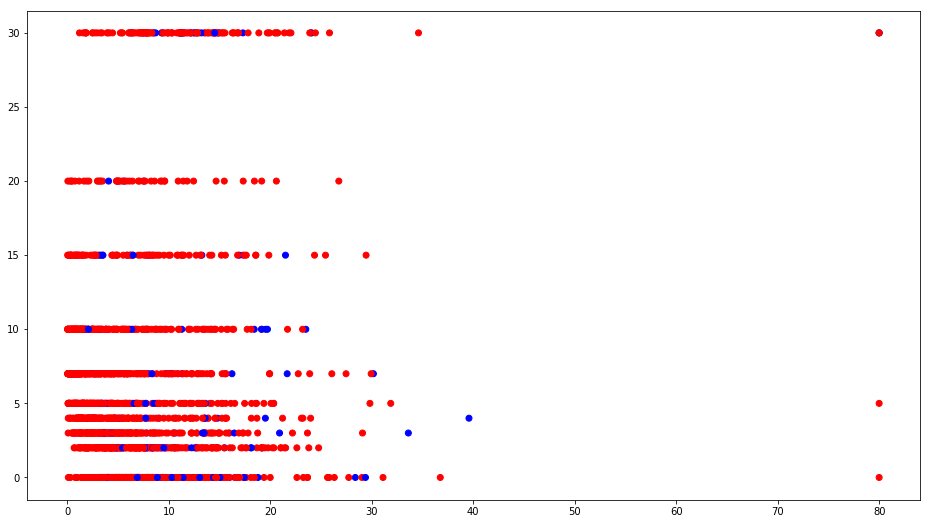

In [98]:
#example_stability.plot('boundary_distance', 'k', kind='scatter', title='k versus epsilon', c='Dataset'.map(max))#, c=Dataset.map(lambda x:'blue' if x=='cifar10' else 'red')())
ax = plt.scatter(example_stability.boundary_distance, example_stability.k, c=example_stability.index.map(lambda x:'blue' if x[1]=='cifar10' else 'red'))
plt.gcf().savefig('k_vs_eps')

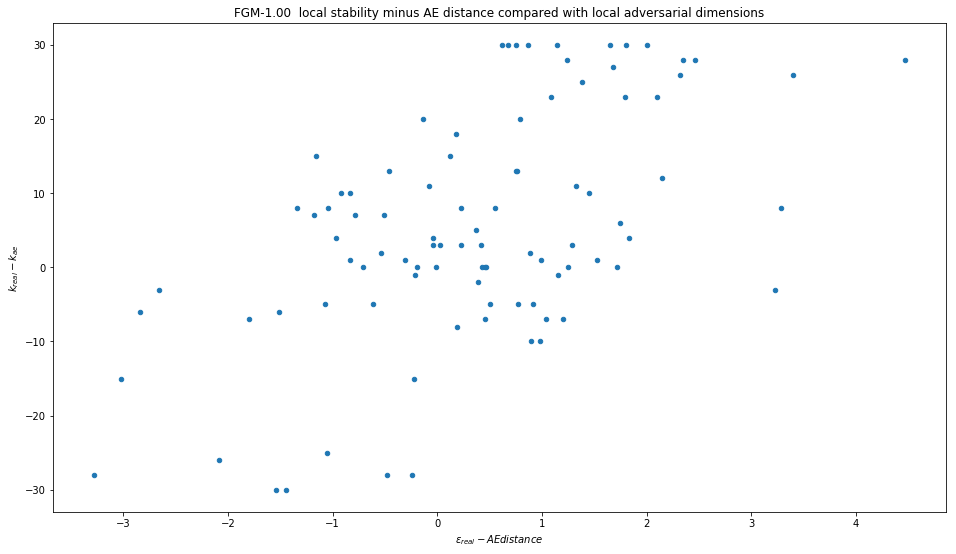

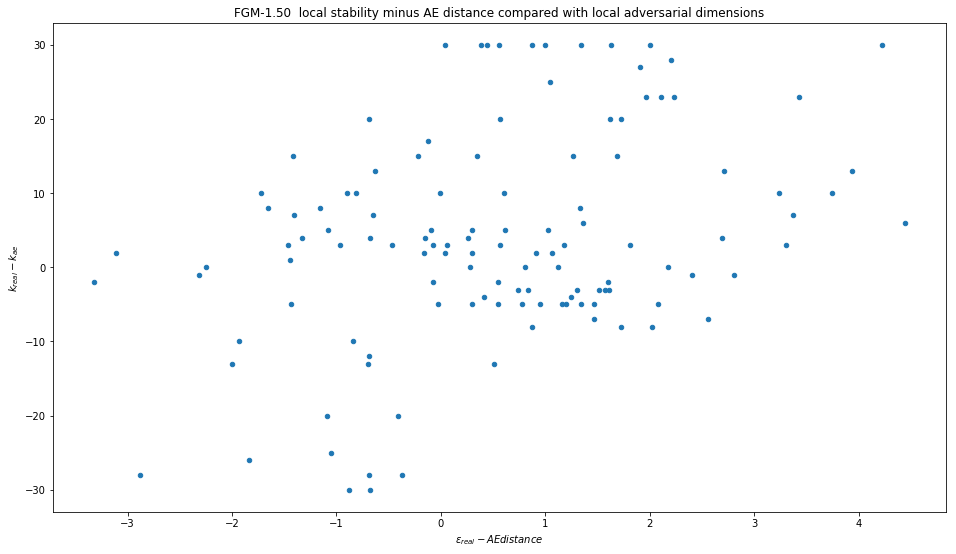

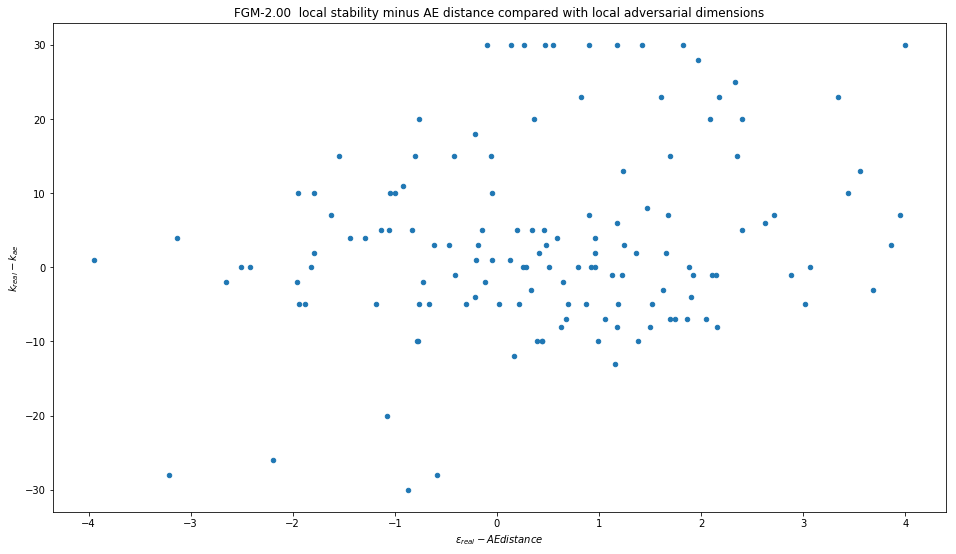

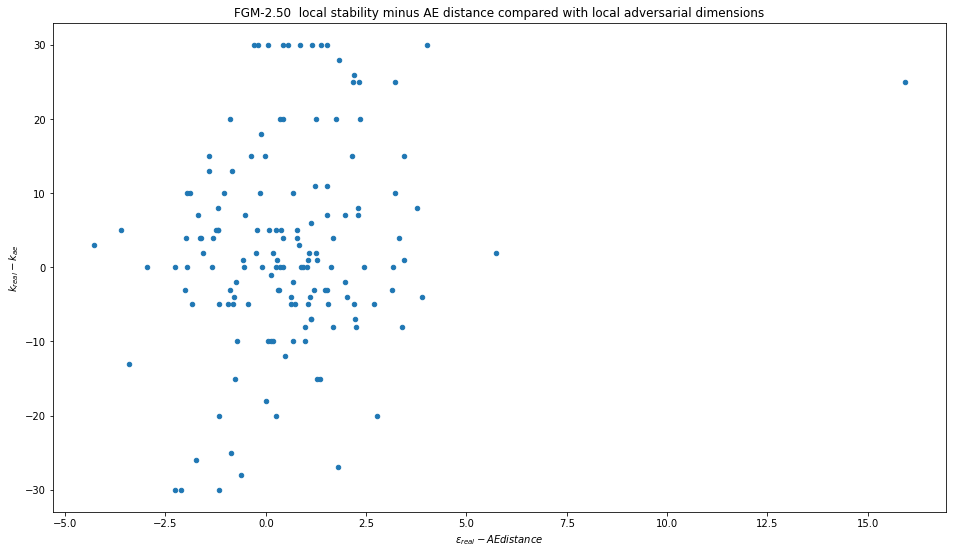

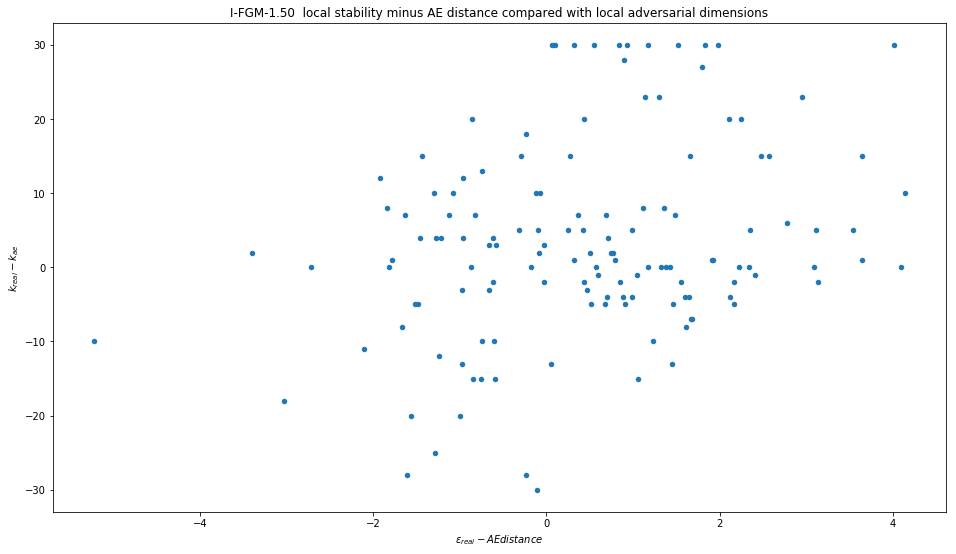

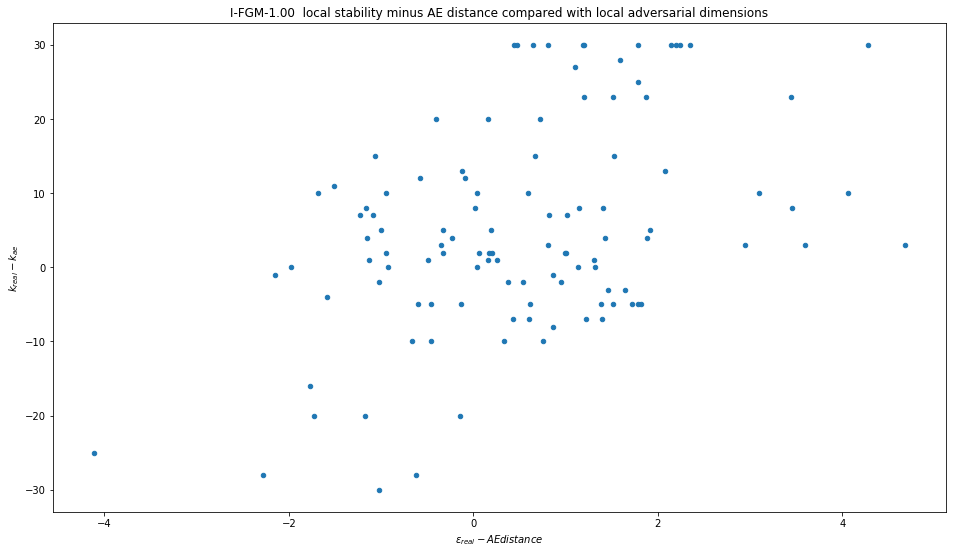

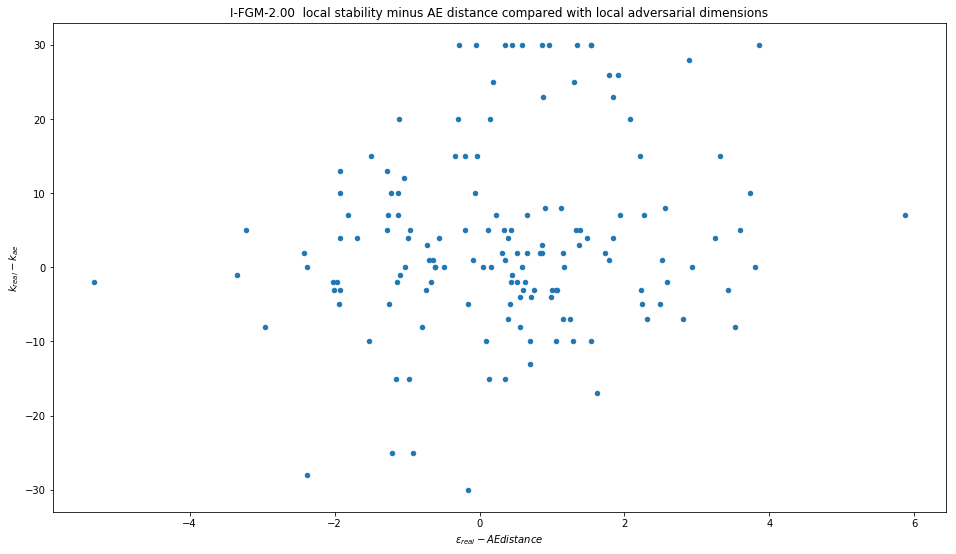

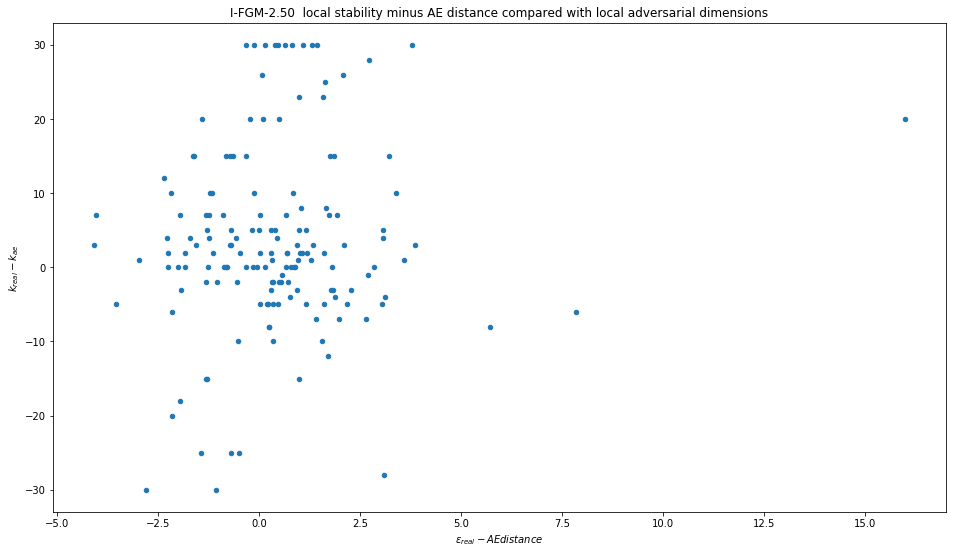

In [65]:
for atk in low_attacks:
    ax = difs[atk].plot('cifar-ae', 'delta_k', kind='scatter', title='{}  local stability minus AE distance compared with local adversarial dimensions'.format(atk))
    ax.set_xlabel('$ \epsilon_{real} - AE distance $')
    ax.set_ylabel('$ k_{real} - k_{ae} $')

In [ ]:
example_stability.loc[pd.IndexSlice[:,'FGM-0.02'], :]

In [ ]:
fig = figure(title='Value of k for which some gaas directions work within epsilon')
#epsilon is 1/10 the closest gaussian boundary
#fig.multi_line(range(len(candidate_dim[dataset])), sorted(candidate_dim[dataset].values()))
#dataset = 'FGM-0.02'
fig.multi_line([list(range(len(candidate_dim[dataset]))) for dataset in candidate_dim.keys()], [sorted(candidate_dim[dataset].values()) for dataset in candidate_dim.keys()], line_color = 'Red')
fig.xaxis.axis_label = "Sorted example"
fig.yaxis.axis_label = "Largest value of k for that example's epsilon"

show(fig)




In [ ]:
for dataset in df.Dataset.unique():
    ax = plt.plot(sorted(candidate_dim[dataset].values()), label= dataset)
plt.legend()

plt.gcf().savefig('k_dim')

In [ ]:
import matplotlib.pyplot as pyplt

In [ ]:
for key1 in candidate_dim.keys():
    for key2, val in candidate_dim[key1].items():
        if np.isnan(candidate_dim[key1][key2]):
            candidate_dim[key1].pop(key1)

In [ ]:
'$\epsilon$'
pyplt.get_backend()

In [ ]:
median_bd = df[df.direction_type=='gaussian'].groupby(['Example#', 'Dataset']).boundary_distance.median()

In [ ]:
df[(df.direction_type=='gaussian') & (df.boundary_distance < 3)].groupby(['Example#', 'Dataset']).boundary_distance.count().hist(by='Dataset')

In [ ]:
test_df = df[(df.direction_type=='gaussian')].groupby(['Example#', 'Dataset']).boundary_distance.agg(lambda x: (x<2).sum())
test_df = test_df.reset_index()
class_1 = test_df[test_df.Dataset=='FGM-0.02']
class_0 = test_df[test_df.Dataset=='cifar10']

In [ ]:
FGMs = ['FGM-0.02', 'FGM-0.03', 'FGM-0.05', 'FGM-0.10',
       'FGM-0.15', 'FGM-0.20', 'FGM-0.25']
IFGMs = ['I-FGM-0.02', 'I-FGM-0.03',
       'I-FGM-0.05', 'I-FGM-0.10', 'I-FGM-0.15', 'I-FGM-0.20',
       'I-FGM-0.25']

In [ ]:
#test_df.head()
bad = test_df[(test_df.Dataset.isin(FGMs)) & (test_df.boundary_distance >0)] #this is testing the number with that boundary distance, not the distance itself
good = test_df[(test_df.Dataset=='cifar10') & (test_df.boundary_distance <1)]


In [ ]:
print(len(good['Example#'].unique()))
print(len(bad['Example#'].unique()))
print(len([i for i in bad['Example#'].unique() if i in good['Example#'].unique() ]))

This means that we could claim that 1157 of the 1500 examples are locally stable in the sense that none of our Gaussian perterbations of size 2 changed the class, while 773 of the AE examples had at least one boundary hit for a Gaussian perturbation size < 2.


In [ ]:
bad[bad.boundary_distance == 30]

In [ ]:
from sklearn.metrics import roc_curve
y_score = np.concatenate([class_0.boundary_distance, class_1.boundary_distance], axis=0)
y_true = np.concatenate([np.zeros((len(class_0),)), np.ones((len(class_1),))])
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.plot(fpr, tpr)

In [ ]:
from sklearn.metrics import auc
auc(fpr, tpr)

In [ ]:
median_bd = median_bd.reset_index()
#median_bd['median_dif_.02'] = 
print(median_bd.head(10))
bound_dists = pd.pivot(median_bd['Example#'], median_bd.Dataset, median_bd.boundary_distance)

In [ ]:

#bound_dists['median_dif_.03'] = bound_dists.cifar10 - bound_dists['FGM-0.03']
ax = bound_dists.hist()

I had expected to see more of a difference in the boundary distance for regular examples (cifar10) versus the stronger FGM, but the distributions look similar.

# 'Subspace dimension'
Next, let's look focus on the gaas 'subspaces' and how well those work-- in the sense of actually creating AE directions within a reasonable distance.

In [ ]:
#create subsets
k2= df[(df.k==2) & (df.direction_type=='gaas')  & (df.Dataset == 'cifar10')].groupby('Example#')
k5= df[(df.k==5) & (df.direction_type=='gaas') & (df.Dataset == 'cifar10')].groupby('Example#')
k10= df[(df.k==10) & (df.direction_type=='gaas') & (df.Dataset == 'cifar10')].groupby('Example#')

In [ ]:
k100= df[(df.k==100) & (df.direction_type=='gaas') & (df.Dataset == 'cifar10')].groupby('Example#')

In [ ]:
#check on 1 example
k10.boundary_distance.agg(lambda x: (x<1).sum()).value_counts() 

In [ ]:
k10.boundary_distance.head()

In [ ]:
median_dist = k10.boundary_distance.median()
median_dist.hist(bins=100)

In [ ]:
#Precalculate data using different distance thresholds.
bd_hists = {}
for d in range(81): #np.linspace(0,10,41):
    hist = np.histogram(k100.boundary_distance.agg(lambda x: (x<d/4).sum()), bins=101)
    bd_hists['_' + str(d)] = ColumnDataSource(dict(x=np.ceil(hist[1][:-1]), y=hist[0]))
source=bd_hists['_1'] #starting source for histogram

In [ ]:
#This is a javascript trick to make the slider do what I want.  
steps = range(81) #np.linspace(0,10,41)
dict_of_sources = dict(zip(
                      [x for x in steps],
                      ['_%s' % x for x in steps])
                      )

js_source_array = str(dict_of_sources).replace("'", "")
#print(js_source_array)

In [ ]:
p = figure(title='Histogram of successful gaas directions for k=100, different distance thresholds', y_range=(0,200))
p.vbar(source=source, x='x', top='y', width=0.7)
p.xaxis.axis_label = "Number of AE using given boundary threshold"
p.yaxis.axis_label = "Count of samples"
#p.y_range = Range1d(0,1300)
code="""    
    var f = slider.get('value'),
        bd_hists = %s, 
        new_source = bd_hists[f].get('data');
    source.set('data', new_source);
    
""" % js_source_array

callback = CustomJS(args = bd_hists, code=code)
s1 = Slider(start=1, end=80, value=1, step=1, callback = callback, title='4 * Distance Threshold')
s1.js_on_change('value', callback)
callback.args["source"] = source
callback.args["slider"] = s1
show(column(s1, p))


Drag the slider above to try out different thresholds.  The slider is for 4 times the thresholds, i.e. intervals of 0.25 L2 distance, to get around how javascript vs python treat floats.  Even at the maximum distance we tried, 20, there are some gaas directions that fail to be adversarial.  There is still some all or nothing feel, where the vast majority of examples either have all 10 directions work or none, with only a few scattered in between.  We can now do the same thing for k=2 and k=5.

In [ ]:
detection_curve = df[(df.direction_type == 'gaas') & (df['Example#']) & (df.Dataset == 'cifar10')].groupby(['Example#', 'k']).boundary_distance.median()
dc = detection_curve.reset_index()

dc2 = df[(df.direction_type == 'gaas') & (df['Example#']) & (df.Dataset == 'I-FGM-0.05')].groupby(['Example#', 'k']).boundary_distance.median()
dc2 = dc2.reset_index()

dc3 = df[(df.direction_type == 'gaas') & (df['Example#']) & (df.Dataset == 'FGM-0.05')].groupby(['Example#', 'k']).boundary_distance.median()
dc3 = dc3.reset_index()

df.Dataset.unique()

In [ ]:
avail_cifar = dc['Example#'].unique()
avail_ifgm = dc2['Example#'].unique()
avail_fgm = dc3['Example#'].unique()


In [ ]:
# Draw independent samples and plot the detection curves for these examples to look for differences
fig, ax = plt.subplots(10, 3, figsize=(30,50))
for i in range(10):
    #print('_________')
    for sample in np.random.choice(avail_cifar,12):
        #print(sample)
        ax[i,0].plot(dc[dc['Example#']==sample].k, dc[dc['Example#']==sample].boundary_distance, label='Example#')
        ax[i,0].set_title('Cifar-10')
        ax[i,0].set_xlabel('k')
        ax[i,0].set_ylabel('median boundary distance')
    for sample in np.random.choice(avail_ifgm,12):
        ax[i,1].plot(dc2[dc2['Example#']==sample].k, dc2[dc2['Example#']==sample].boundary_distance, label='Example#')
        ax[i,1].set_title('I-FGM-0.05')
        ax[i,1].set_xlabel('k')
        ax[i,1].set_ylabel('median boundary distance')        
    for sample in np.random.choice(avail_fgm,12):
        ax[i,2].plot(dc3[dc3['Example#']==sample].k, dc3[dc3['Example#']==sample].boundary_distance, label='Example#')
        ax[i,2].set_title('FGM-0.05')
        ax[i,2].set_xlabel('k')
        ax[i,2].set_ylabel('median boundary distance')
fig.savefig('Detection curve samples')            

In [ ]:
np.random.choice(avail_cifar, 10)

In [ ]:
fig, ax = plt.subplots()
for ex in dc2['Example#'].unique():
    ax.plot(dc2[dc2['Example#']==ex].k, dc2[dc2['Example#']==ex].boundary_distance, label='Example#', )
    #detection_curve[detection_curve['Example#']==ex].plot(x='k', y='boundary_distance', label='Example#')
ax.set_xlabel('k')
ax.set_ylabel('median boundary distance')

In [ ]:
dc3 = df[(df.direction_type == 'gaas') & (df['Example#']<=10) & (df.Dataset == 'FGM-0.02')].groupby(['Example#', 'k']).boundary_distance.median()
dc3 = dc3.reset_index()
fig, ax = plt.subplots()
for ex in dc3['Example#'].unique():
    ax.plot(dc3[dc3['Example#']==ex].k, dc3[dc3['Example#']==ex].boundary_distance, label='Example#' )
    #detection_curve[detection_curve['Example#']==ex].plot(x='k', y='boundary_distance', label='Example#')
ax.set_xlabel('k')
ax.set_ylabel('median boundary distance')

In [ ]:
#Same calculations for k=2,5.
bd_hists5 = {}
for d in range(81): #np.linspace(0,10,41):
    hist = np.histogram(k5.boundary_distance.agg(lambda x: (x<d/4).sum()), bins=6)
    bd_hists5['_' + str(d)] = ColumnDataSource(dict(x=np.ceil(hist[1][:-1]), y=hist[0]))
source5=bd_hists5['_1'] #starting source for histogram

p5 = figure(title='Histogram of successful gaas directions for k=5, different distance thresholds', y_range=(0,1600))
p5.vbar(source=source5, x='x', top='y', width=0.7)
p5.xaxis.axis_label = "Number of AE using given boundary threshold"
p5.yaxis.axis_label = "Count of samples"
#p.y_range = Range1d(0,1300)
code5="""    
    var f = slider.get('value'),
        bd_hists5 = %s, 
        new_source = bd_hists5[f].get('data');
    source5.set('data', new_source);    
""" % js_source_array

callback5 = CustomJS(args = bd_hists5, code=code5)
s5 = Slider(start=1, end=80, value=1, step=1, callback = callback5, title='4 * Distance Threshold')
#s5.js_on_change('value', callback5)
callback5.args["source5"] = source5
callback5.args["slider"] = s5

bd_hists2 = {}
for d in range(81): #np.linspace(0,10,41):
    hist = np.histogram(k2.boundary_distance.agg(lambda x: (x<d/4).sum()), bins=3)
    bd_hists2['_' + str(d)] = ColumnDataSource(dict(x=np.ceil(hist[1][:-1]), y=hist[0]))
source2=bd_hists2['_1'] #starting source for histogram

p2 = figure(title='Histogram of successful gaas directions for k=2, different distance thresholds', y_range=(0,1600))
p2.vbar(source=source2, x='x', top='y', width=0.7)
p2.xaxis.axis_label = "Number of AE using given boundary threshold"
p2.yaxis.axis_label = "Count of samples"
#p.y_range = Range1d(0,1300)
code2="""    
    var f = slider.get('value'),
        bd_hists2 = %s, 
        new_source = bd_hists2[f].get('data');
    source2.set('data', new_source);    
""" % js_source_array

callback2 = CustomJS(args = bd_hists2, code=code2)
s2 = Slider(start=1, end=80, value=1, step=1, callback = callback2, title='4 * Distance Threshold')
#s2.js_on_change('value', callback2)
callback2.args["source2"] = source2
callback2.args["slider"] = s2

show(layout([[s5, s2], [p5, p2]], responsive=True))


There's not much more interesting here.  Next, let's look at the levels of attack and different directions.  
# Average distances to boundary

In [ ]:
grouped = df.groupby(['Dataset', 'direction_type'])
plot_vals = grouped.boundary_distance.mean()
plot_df = plot_vals.unstack('Dataset')
print(plot_df)

Comparing some of this with Figure 4 from Tramer et al Subspace, we have larger distances overall (probably because cifar vs mnist), but a somewhat similar pattern (we didn't do interboundary distance or legitimate direction). 

In [ ]:
ax = plot_df.plot(sort_columns=['direction_type'], title='Mean distance to boundary by direction type and starting point')

Notice that the gaas_convex_combo is closer to a boundary, on par with the gradient.  This is expected, since the convex combination uses a coefficient vector with norm 1 and positive entries.  This means that the combo points in a direction 'between' the gaas directions.  The gaas directions are spread around the gradient, so the combo is closer to the gradient direction.  We might thus expect that the gaas success would decrease with k but the convex combo success would remain similar.

In [ ]:
df.hist('boundary_distance', by=['k', 'direction_type'], bins=40)

In [ ]:
df.groupby(['k', 'direction_type']).boundary_distance.mean()

In [ ]:
df.groupby(['k', 'direction_type']).boundary_distance.median()

In [ ]:
print(df.boundary_distance[df.direction_type == 'gradient'].mean())
print(df.boundary_distance[df.direction_type == 'gradient'].median())

In [ ]:
ax = grouped.boundary_distance.median().unstack('Dataset').plot(title='Median distance to boundary by direction type and starting point')

In [ ]:
counts = df.groupby(['y', 'y_hat']).ell2_grad.count()
counts.reset_index().plot.scatter('y', 'y_hat', s = counts)

This plot is a little loose, but gives a sense of the starting vs ending classes, which aren't evenly distributed but don't seem to have a strong pattern. 

Next, we look at **class purity**, or the distribution of how many different ending classes were reached for a given starting example.  It's often the case that most examples reach just 2 or 3 other classes out of the 10, but unfortunately this doesn't look very different for the real vs AE starting points.

In [ ]:
purity_group = df[df.direction_type == 'gaussian'].groupby(['Example#', 'Dataset'])
ax = purity_group.y_hat.nunique().hist(by='Dataset')

We're also interested in how the loss changes when we move different distances in the different directions.  This is slightly misleading, because we aren't testing various distances in each direction.  Rather, we record the distance to boundary (if we reach it).  Still, it seems worth looking at whether a greater distance is needed to produce the same loss, or creates a greater loss in order to change the class. 

To start, let's restrict to 'close' boundaries.

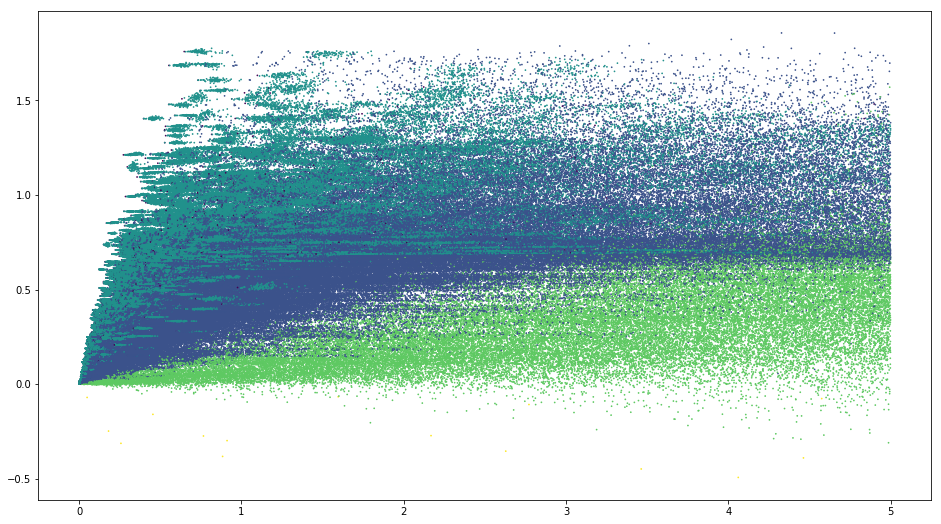

In [73]:
close = df[df.boundary_distance < 5]
type_index = {j:i for i, j in enumerate(close.direction_type.unique())}
plt.scatter(close.boundary_distance, close.delta_loss, c = close.direction_type.map(type_index), label = close.direction_type, s = 0.5)
#plt.legend()

Not that useful, though it does show a different pattern for the direction types (as we would expect).  Let's look at each separately (but combining all FGMs).

These histograms show the counts over boundary distance and change in loss.

In [ ]:
fig, axs = plt.subplots(5, 2,  figsize=(30,40))
for i, direction in enumerate(close.direction_type.unique()):
    axs[i,0].set_title('cifar10' + ', ' + direction)
    axs[i,0].hist2d(close[(close.direction_type == direction) & (close.Dataset == 'cifar10')].boundary_distance, close[(close.direction_type == direction) & (close.Dataset == 'cifar10')].delta_loss, bins=50, norm=colors.LogNorm())
    axs[i,0].set_xlabel('Boundary Distance')
    axs[i,0].set_ylabel('Change in Loss')
    axs[i,1].set_title('FGM' + ', ' + direction)
    axs[i,1].hist2d(close[(close.direction_type == direction) & (close.Dataset != 'cifar10')].boundary_distance, close[(close.direction_type == direction) & (close.Dataset != 'cifar10')].delta_loss, bins=50, norm=colors.LogNorm())
    axs[i,1].set_xlabel('Boundary Distance')
    axs[i,1].set_ylabel('Change in Loss')
    

Note the log-count coloring.  The random (gaussian) direction is the main one that induces negative loss while changing class.

In [ ]:
df.delta_loss.describe()